VaR = max loss when im @ 95% CL
CVaR = when in 5%, whats avg loss

# VaR

1. confidence lv
2. series of loss observed
3. compute loss.quantile() at a specfic confidence
4. VaR = computed quantile at desired confidence
5. scipy.stats loss distribution: % point function, ppf()

. = belongx

In [130]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import random
from pypfopt.efficient_frontier import EfficientCVaR

In [131]:
observations = pd.Series(norm.rvs(size=500))

loss = pd.Series(observations)
VaR_95 = loss.quantile(0.995)
print(VaR_95)

2.5259254003916984


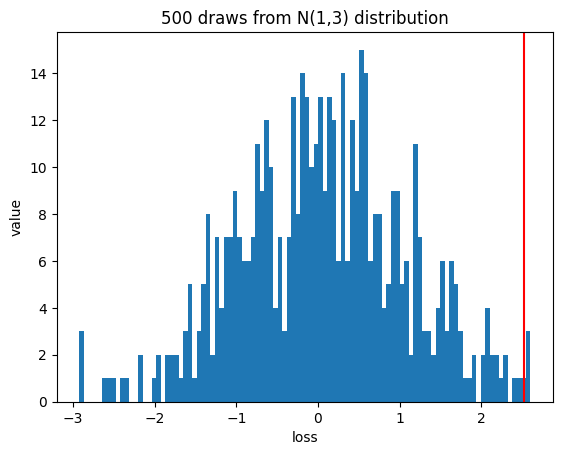

In [132]:
plt.hist(observations, bins=100)
plt.xlabel('loss')
plt.ylabel('value')
plt.title('500 draws from N(1,3) distribution')
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.show()

# CVaR

1. CL
2. sample from loss distribution
3. compute VaR at a CL
4. compute CVaR as expected loss; scipy.stats.norm.exp()

scipy.stats.norm = normal bell curve
lambda x: x = for each x, take 

In [133]:
#assume normal distribution N(0,1), with loss 

losses = pd.Series(norm.rvs(size=1000))

VaR_95 = norm.ppf(0.95)
CVaR_95 = (1/(1-0.95)) * norm.expect(lambda x: x, lb = VaR_95)

print(CVaR_95)

2.062712807818916


In [134]:
draws = norm.rvs(size=100)
VaR_99 = np.quantile(draws,0.99)
print(VaR_99)

1.7010508643279483


In [135]:
# data doesnt follow N(0,1), define our own

losses = np.array([6,5,8,1,4,7,2])

pm = losses.mean()
ps = losses.std()

VaR_95 = norm.ppf(0.95, loc = pm, scale = ps)
CVaR_95 = (1/(1-0.95)) * norm.expect(lambda x:x, loc = pm, scale = ps, lb = VaR_95)

print(CVaR_95)

9.60976555119656


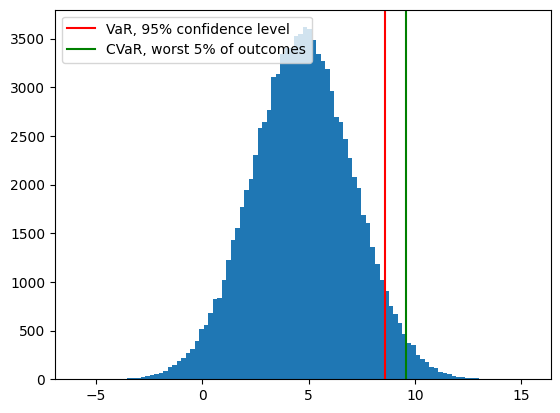

In [136]:
plt.hist(norm.rvs(size = 100000, loc = pm, scale = ps), bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR, 95% confidence level")
plt.axvline(x = CVaR_95, c='g', label = "CVaR, worst 5% of outcomes")
plt.legend(); plt.show()

enterprise = risk appetite, us = risk tolerance

generally, loss distribution = continuious loss distrbution
1. normal distribution: for large sample
2. student t-dis: small, fatter tail

# t distribution & VaR


1. import t
2. fit loss data using t.fit()
3. VaR
4. df, np.linspace()

rolling(30) = do it 30 at a time, ex. MA21

enumerate() = gives position number & the item

variable[i] = give me the item at position i, 

    list_1 = [1,5,2,7]
    list_1[3] = 2

ppf() = gives normal bell curve cut off point for VaR

pd.DataFrame(data=, index=, columns= )

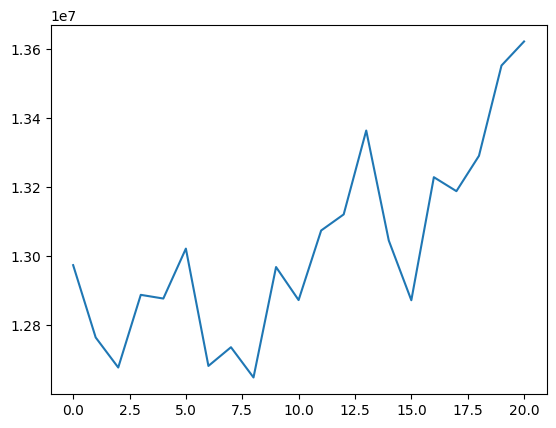

In [137]:
losses = [random.randint(1, 100) for i in range(50)]
df = pd.DataFrame(losses, columns = ['losses'])

# Create rolling window parameter list
mu = df['losses'].rolling(30).mean()
sigma = df['losses'].rolling(30).std()

# make a list of this, by looping through that
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)if not pd.isna(s)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) for params in rolling_parameters ] )

# Plot the minimum risk exposure over the 2005-2010 time period
plt.plot( VaR_99 * 100000)
plt.show()

# t distribution & CVaR

1. t.fit() = to find the curve's parameter (the numbers that describe the shape)
2. then use .ppf() to find VaR
3. use t.expect(lambda...) to compute CVaR

if rollling, need df instead of array

t.expect(lambda x: x, df, mean, std, lower bound)

crisis_losses = just random sample number, and t-student will use this to generate a curve, which potentially could very extreme (ex. a financial crash that we haven't seen)

higher df for t, more looks like a norm dis

In [138]:
crisis_losses = np.array([random.randint(1,100) for i in range(50)])

# Fit the Student's t distribution to crisis losses
p = t.fit(crisis_losses)

# Compute the VaR_99 for the fitted distribution
VaR_99 = t.ppf(0.99, *p)

# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)

116.57080015177056


# MPT Modern Portfolio Theory: mean-var optimization
1. mean-var objective: max exp return
2. CVaR: min exp loss at given CL

w* = optimal port weight

# CVaR min using Pyportfolio opt

1. create EfficientCVaR object with asset returns
2. find w* using .min_cvar()

cant always assume VaR is norm dis quantile
1. we fit a distribution that match the data: fitted.evaluate()
2. resample from fitted distribution (monte Carlo): fitted.resample()
3. VaR

theres no student t in here

fitted.evaluate(x) = pdf value at each those pt, the y

pdf = shape of dis, where value most likely show up

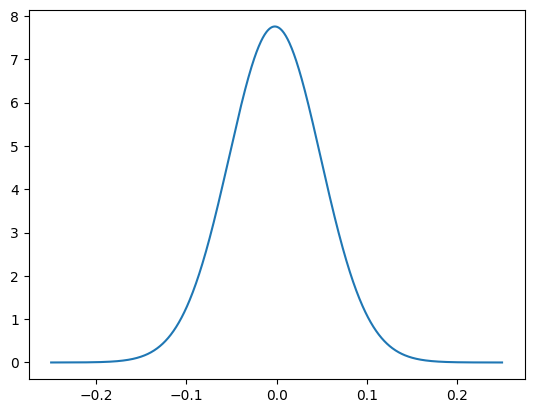

0.08346630810492452


In [139]:
# assume this is the input data we got
returns = np.random.normal(0, 0.05, 1000) # here we generate using norm for convenience, but reality it wont be norm dis

# fit a t-dis for now for convenience, later will have other method to fit skewed data
fitted_p = t.fit(returns) # returns (df, loc, scale)
fitted = t(*fitted_p)

# Visualize the fitted distribution with a plot
x = np.linspace(-0.25,0.25,1000) # give me a bunch even spaced btw 2 endpt
plt.plot(x,fitted.pdf(x)) # = plt.plot(x,y)

# if p = (df, loc, scale) already defined, then t(*p) is that 
plt.show()


# Create a random sample of 100,000 observations from the fitted distribution
sample = fitted.rvs(100000)

# Compute and display the 95% VaR from the random sample
VaR_95 = np.quantile(sample, 0.95)
print(VaR_95)


# Minimize CVaR


Mean-var is finding tradeoff: ef = EfficientFrontier(exp_return, cov_matrix)

CVaR min only care min risk: ec = EfficientCVaR(none, return)

In [140]:
np.random.seed(42)

returns = pd.DataFrame({
    'JPMorgan': np.random.normal(0.005, 0.08, 60),
    'Goldman': np.random.normal(0.007, 0.09, 60),
    'MorganStanley': np.random.normal(0.003, 0.10, 60),
    'BankOfAmerica': np.random.normal(0.002, 0.11, 60),
    'Citigroup': np.random.normal(0.001, 0.12, 60)
})

# retrieve EfficientCVaR(exp_return, return, solver)
ec = EfficientCVaR(None, returns)

# find port w, min_cvar is a function of EfficientCVaR
ec.min_cvar()
optimal_w = ec.clean_weights()
column_names = returns.columns.tolist()

# piece together
mapped_weights = {}

for index, weight in optimal_w.items(): #there are 2 element in optimal_w, then assign two names to them
    bank_name = column_names[index]
    mapped_weights[bank_name] = weight
# 1) a name lookup
# 2) assign this name to an existing number


print (mapped_weights)

{'JPMorgan': 0.36597, 'Goldman': 0.0, 'MorganStanley': 0.09856, 'BankOfAmerica': 0.33086, 'Citigroup': 0.2046}


# CVaR risk mgmt & Crisis

derive the 95% CVaR min port for before, during, after crisis

In [141]:
returns = pd.DataFrame({
    'JPMorgan': np.random.normal(0.005, 0.08, 60),
    'Goldman': np.random.normal(0.007, 0.09, 60),
    'MorganStanley': np.random.normal(0.003, 0.10, 60),
    'BankOfAmerica': np.random.normal(0.002, 0.11, 60),
    'Citigroup': np.random.normal(0.001, 0.12, 60)
})

returns_dict = {
    'before': returns.iloc[:20],
    'during': returns.iloc[20:40],
    'after': returns.iloc[40:]
}

# store
ec_dict = {}
for x in returns_dict: # 3 iterations, x rep one at a time
    ec_dict[x] = EfficientCVaR(None, returns_dict[x])

names = list(returns.columns)

for period in returns_dict:
    ec_dict[period].min_cvar()
    w = ec_dict[period].clean_weights()
    print(period)
    for i in w:
        w_name = names[i]
        print(w_name, w[i])

before
JPMorgan 0.66271
Goldman 0.32611
MorganStanley 0.0
BankOfAmerica 0.01118
Citigroup 0.0
during
JPMorgan 0.32048
Goldman 0.0
MorganStanley 0.07549
BankOfAmerica 0.32396
Citigroup 0.28007
after
JPMorgan 0.50482
Goldman 0.0
MorganStanley 0.4037
BankOfAmerica 0.09148
Citigroup 0.0


# Black Scholes & option price

Euro option: underlying is the same as having a stock in port

Spot price S > option price V rise

Delta = dV/dS 

hedge one share with 1/delta options

delta neutral = change in S + delta V/delta = 0

black_scholes(S, X, T, r, sigma, option_type, q=0)

np.random.normal(mean,std,size)

In [191]:
# mean = 0.03% per day, std = 1% per day
IBM_returns = np.random.normal(0.0003, 0.01, 100)

# Compute the volatility as the annualized standard deviation of IBM returns
sigma = np.sqrt(252) * IBM_returns.std() # convert return from annual to daily

# Compute the Black-Scholes option price for this volatility
value_s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, sigma = sigma, option_type = "call")

# Compute the Black-Scholes option price for 2x the volatility
value_2s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, sigma = 2 * sigma, option_type = "call")

print(value_s, value_2s)

11.388936169908717 14.116146634460058


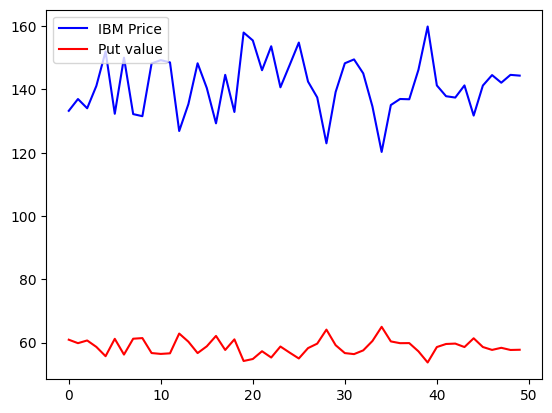

In [199]:
# spot price
IBM = np.random.normal(140,10,200)

# return %
IBM_returns = np.diff(IBM)/IBM[:-1]
sigma = np.sqrt(252) * IBM_returns.std()

# first 50
IBM_spot = IBM[:50]

# start a array, with 100 spots filled with placeholer 0
option_values = np.zeros(IBM_spot.size)

# find option value
for i,S in enumerate(IBM_spot):
    option_values[i] = black_scholes(S = S, X = 140, T = 0.5, r = 0.02, sigma = sigma, option_type = "put")

plt.plot(IBM_spot, color ="blue", label="IBM Price")
plt.plot(option_values, color = "red", label = "Put value")
plt.legend(loc = "upper left")
plt.show()

delta hedge

In [204]:
# Compute the annualized standard deviation of `IBM` returns
sigma = np.sqrt(252) * IBM_returns.std()

# Compute the Black-Scholes value at IBM spot price 70
value = black_scholes(S = 70, X = 80, T = 0.5, r = 0.02, sigma = sigma, option_type = "put")

# Find the delta of the option at IBM spot price 70
delta = bs_delta(S = 70, X = 80, T = 0.5, r = 0.02, sigma = sigma, option_type = "put")

# Find the option value change when the price of IBM falls to 69.5
value_change = black_scholes(S = 69.5, X = 80, T = 0.5, r = 0.02, 
                             sigma = sigma, option_type = "put") - value

print( (69.5 - 70) + (1/delta) * value_change )

0.0017572255072155762
